In [1]:
using Plots
using DiffEqFlux, OrdinaryDiffEq, Flux, Optim
import LinearAlgebra: norm
using NPZ
using Plots
include("/Users/piotrsokol/Documents/RNNODE.jl/src/rnn_ode.jl")

generate_adj_saving_callback

In [277]:
alpha = 1.1
A = npzread("bifcurve.npz")["alpha"]
T = npzread("bifcurve.npz")["theta"]

Acut = reverse(A[T.<=pi/2])
Tcut = reverse(T[T.<=pi/2]);

In [283]:
offset = 0.1

idx = findfirst(x->x>= alpha, Acut[:])-1
theta_strong_resonance = Tcut[idx]+offset
theta_strong_resonance = pi/2
wrsr = alpha*[cos(theta_strong_resonance) -sin(theta_strong_resonance); sin(theta_strong_resonance) cos(theta_strong_resonance)];
wrsr = convert(Array{eltype(rnn.Wᵣ)}, wrsr)

theta_NS = Tcut[idx]-offset
wrNS = alpha*[cos(theta_NS) -sin(theta_NS); sin(theta_NS) cos(theta_NS)];
wrNS = convert(Array{eltype(rnn.Wᵣ)}, wrNS)

2×2 Array{Float32,2}:
 0.145108  -1.09039
 1.09039    0.145108

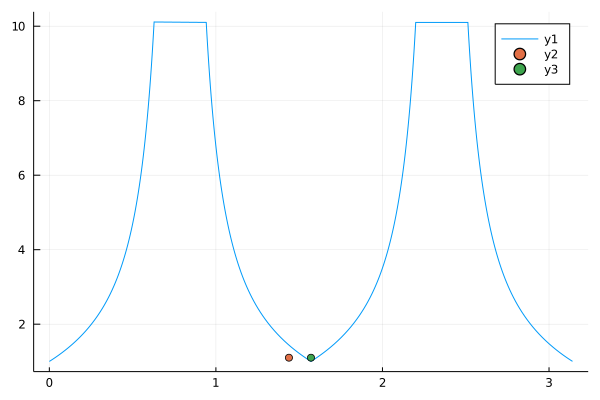

In [284]:
plot(T',A')
scatter!([theta_NS],[alpha])
scatter!([theta_strong_resonance],[alpha])

In [285]:
function dudt_(h,p,t)
  σ =tanh
  Wᵣ = reshape(p,2,2)
  ḣ = σ.(Wᵣ*h ).-h
  return ḣ
end
ff = ODEFunction{false}(dudt_,tgrad=basic_tgrad)
prob(p) = ODEProblem{false}(ff,u₀,tspan,p)

prob (generic function with 1 method)

In [286]:
u₀ = 2rand(eltype(eltype(rnn.Wᵣ)), 2,1).-1
tspan = [0.f0,120.f0];

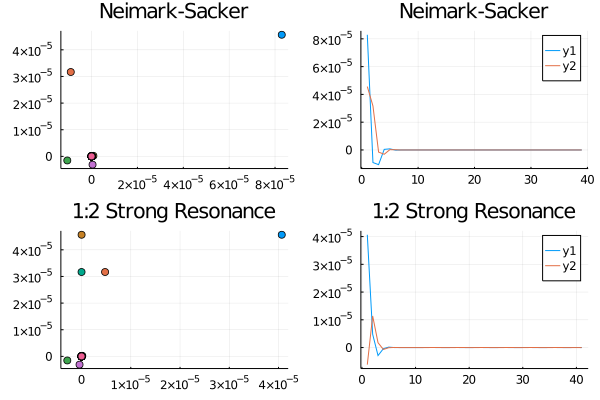

In [295]:
x = range(-1, stop=1, length=6)
y = range(-1, stop=1, length=6)
kwargs = (:alg=>Euler(), :dt=>1.)

#alg=Euler(),dt=1.

solNS_euler = solve(prob(wrNS),alg=Vern9())
scNS_euler = scatter(Array(solNS_euler)[1,1,20:end]',Array(solNS_euler)[2,1,20:end]',label="")
#quiver!(x, y', quiver=(x,y)->dudt_(vcat(x,y),wrNS,0); c=:black)

tsNS_euler=plot(Array(solNS_euler[:,1,20:end])')

solsr_euler = solve(prob(wrsr),alg=Vern9() )
scsr_euler = scatter(Array(solsr_euler)[1,1,20:end]',Array(solNS_euler)[2,1,20:end]',label="")
#quiver!(x, y', quiver=(x,y)->dudt_(vcat(x,y),wrsr, 0); c=:black)
tssr_euler=plot(Array(solsr_euler[:,1,20:end])')

plttop = plot( scNS_euler, tsNS_euler, title="Neimark-Sacker" )
pltbot = plot( scsr_euler, tssr_euler,title="1:2 Strong Resonance" )

plotout = plot(plttop,pltbot, layout=grid(2,1))


In [296]:
savefig(plotout,"Continuous.png")